# OBJECTIVE

The objective of these lines of code is to build a reliable model that can predict insurance charges for a given individual based on information given by such individual.

This is a common practice in the Insurance industry. The customer(Insured) fills information requested for by the insurance company and some of these information are used to determine the premium(charges) 

This model will hence make the rating process easy for the insurer

# Import Libaries

In [1]:
# First import the neccesary libaries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load Data

In [2]:
# Load the dataset
data = pd.read_csv('insurance_data.csv')

# Data Exploration

In [3]:
#view first entries
data.head()

age     sex     bmi  children smoker  Claim_Amount  past_consultations  \
0  45.0    male  28.700       2.0     no   32993.77432                16.0   
1  64.0    male  34.500       0.0     no   38448.37757                 8.0   
2  19.0  female  32.110       0.0     no   50778.14448                15.0   
3  36.0    male  28.880       3.0     no   33741.00388                10.0   
4  19.0  female  24.605       1.0     no   12198.20493                16.0   

   num_of_steps  Hospital_expenditure  NUmber_of_past_hospitalizations  \
0      902022.0          8.640895e+06                              1.0   
1      956604.0          1.102239e+07                              1.0   
2      758688.0          1.642626e+06                              0.0   
3      879560.0          1.985637e+06                              1.0   
4      793026.0          1.000938e+07                              1.0   

   Anual_Salary     region      charges  
0  9.436591e+07  southwest   8027.96800  
1  2.300219e+08  southwest  13822.80300  
2  4.644349e+07  northwest   2130.67590  
3  1.306169e+08  northeast   6748.59120  
4  6.113392e+07  northwest   2709.24395

Our dataset is loaded successfully and the column names are well joined with underscores(_). I also love how our response variable i.e the variable we want to predict ("charges") is the last column of the dataframe. We should however make changes to the column name "NUmber_of_past_hospitalizations" from 'U' to 'u' to avoid future mixups

In [3]:
data = data.rename(columns={'NUmber_of_past_hospitalizations':'Number_of_past_hospitalizations'})

In [4]:
data.sample(5)

age     sex    bmi  children smoker  Claim_Amount  past_consultations  \
866   19.0  female  24.70       0.0     no   3965.606464                 7.0   
3537  23.0    male  34.40       0.0     no  18674.719700                19.0   
4234  22.0  female  21.28       3.0     no  32592.553010                20.0   
1302  24.0  female  27.72       0.0     no  19221.179530                 4.0   
4350  58.0  female  39.05       0.0     no  30333.000330                21.0   

      num_of_steps  Hospital_expenditure  Number_of_past_hospitalizations  \
866       757132.0           5513272.227                              0.0   
3537      742189.0           4955339.824                              0.0   
4234      831898.0           8307091.343                              1.0   
1302      781129.0           6076092.947                              0.0   
4350      935611.0           3445156.043                              1.0   

      Anual_Salary     region     charges  
866   2.952277e+07  southwest   1737.3760  
3537  6.062705e+06  southwest   1826.8430  
4234  5.570944e+07  northwest   4296.2712  
1302  9.535657e+07  southeast   2464.6188  
4350  1.422656e+08  southeast  11856.4115

In [7]:
data.shape

(10008, 13)

The dataset contains 10,008 rows and 13 columns

In [8]:
data.drop_duplicates()
data.shape

(10008, 13)

After dropping duplicates, the shape remains the same which means the data contained no duplicates

Let's have a view of how each column is distributed

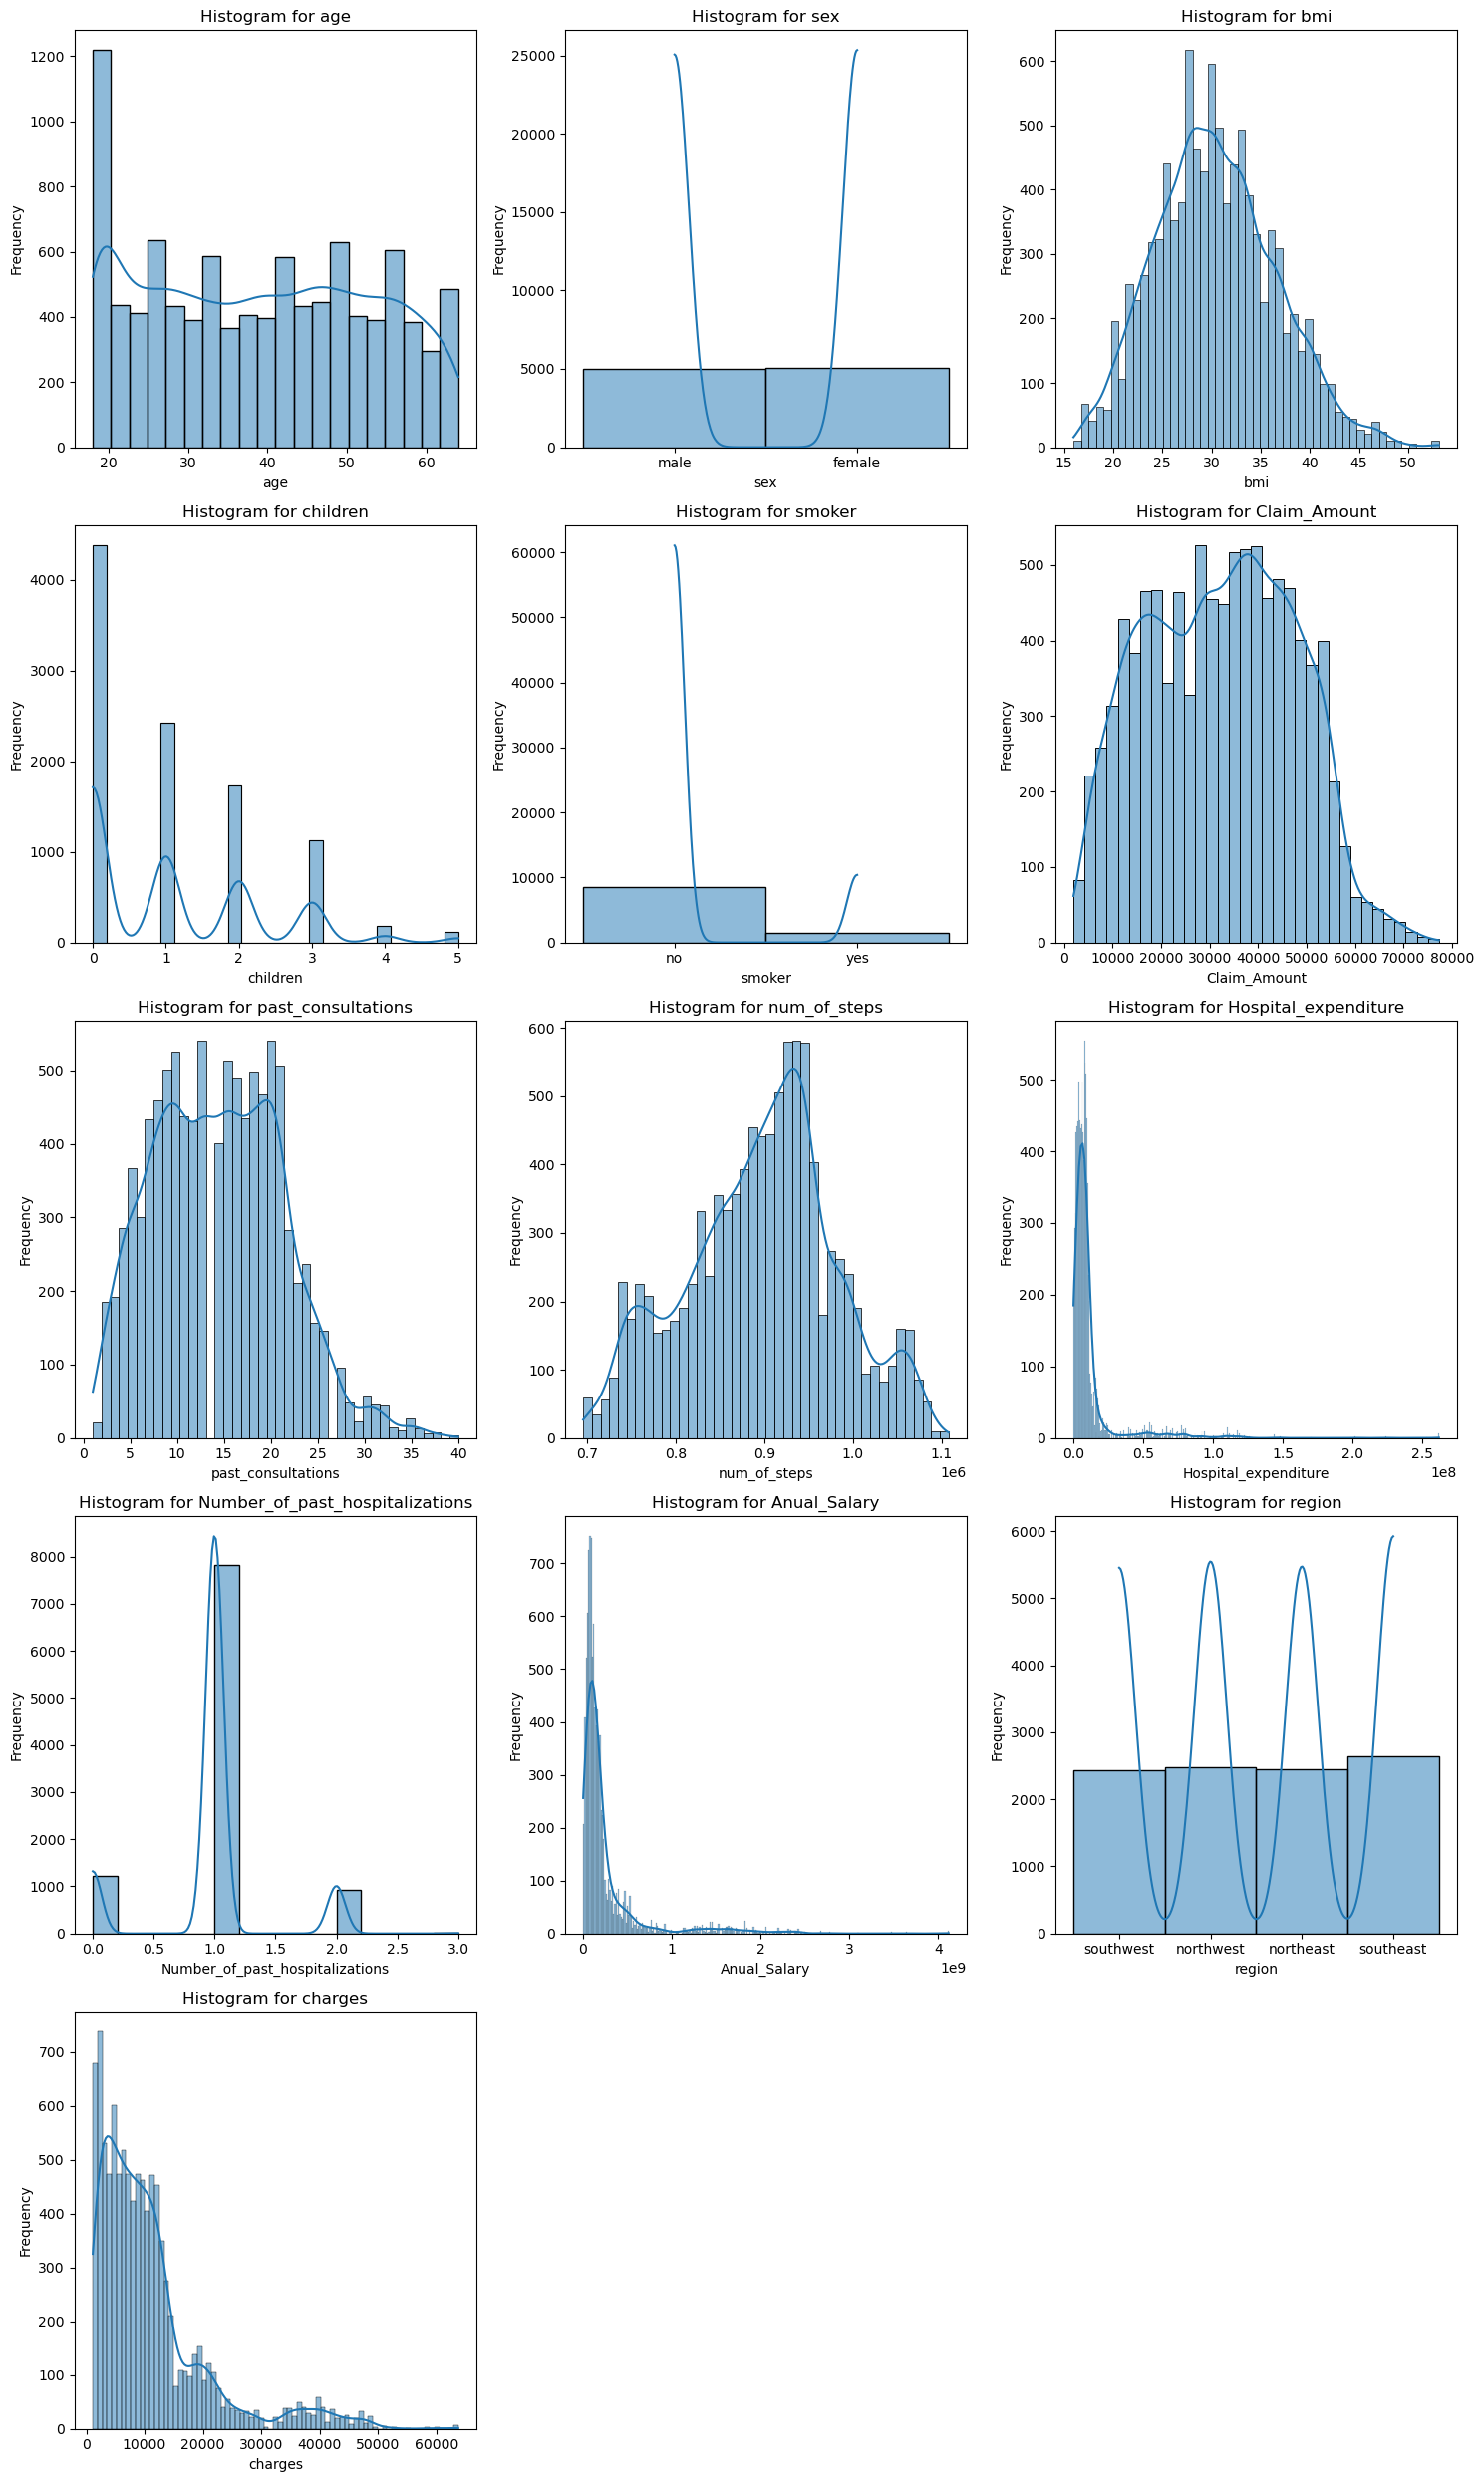

In [9]:
num_cols = len(data.columns)
num_rows = num_rows = (num_cols - 1) // 3 + 1

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    sns.histplot(data[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    
for j in range(num_cols, num_rows * 3):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

Interesting to see the variations in each column. While majority are skewed to the right, some are evenly distributed. From the visualization above we can agree that:

1. Majority of the insureds are aged 20, have no children, do not smoke, been hospitalized just once.
2. Region and sex are almost evenly distributed

Let's further explore how variables interact with 'charges' and with one another

Text(0.5, 1.0, 'Charges vs Age')

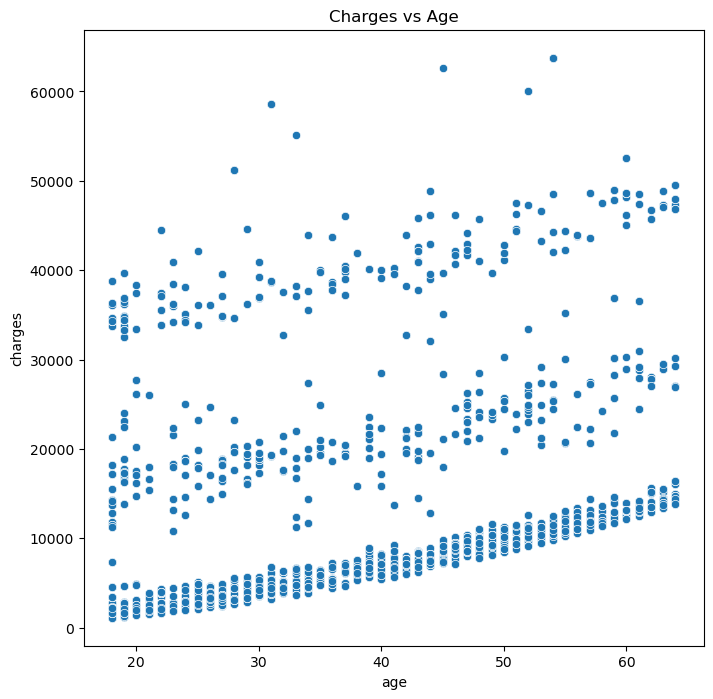

In [10]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=data, x='age', y='charges')
plt.title('Charges vs Age')

This is quite interesting, a linear relationship obviously exists between charges and age but apprearing in three stages or divisions which suggests that there is indeed a relationship between charges and age but is depending on another variable. Lets find out these variable(s)

Text(0.5, 1.0, 'Charges vs Age by Smoker Status')

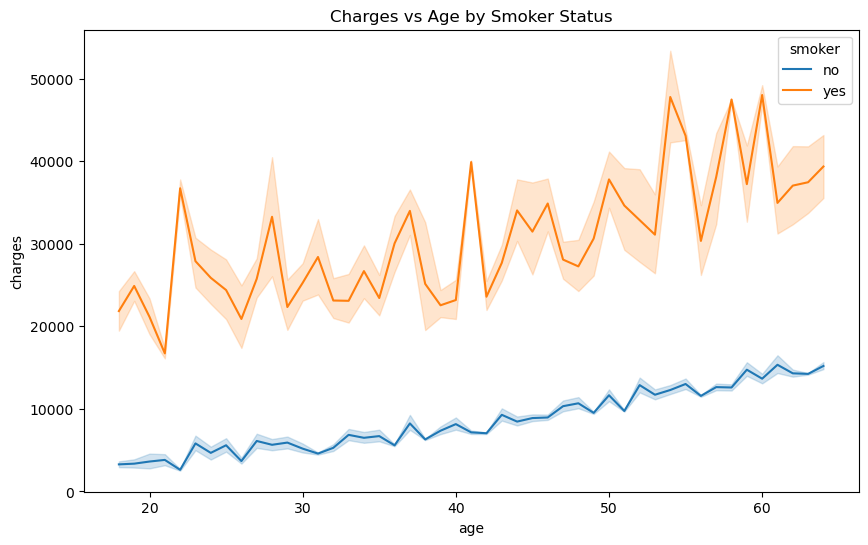

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='age', y='charges', hue='smoker')
plt.title('Charges vs Age by Smoker Status')

And there we have it! Smokers generally pay higher charges than non smokers, such charges further increase in relative to their age. This is no surprise as insurers believe that as a person gets older, they get more exposed to illnesses and same applies to smokers. As a result of this underlying 'extra' risk, an extra charge is placed upon them. Now we see why the previous charges vs Age plot seem to have categories/divisions.

Now let's explore the Body Mass Index(BMI). We will use the guidelines extablished by World Health Organization which categorises BMI as follows:

BMI < 18.5 as Underweight,

18.5 ≤ BMI < 25 as Normal weight,

25 ≤ BMI < 30 as Overweight and

BMI ≥ 30 as Obesity

In [12]:
def categorise_bmi(bmi):
    """
    Categorizes bmi into categories stated above.
    """
    
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal weight'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obesity'

In [14]:
#create a column containing the bmi categories
data['bmi_category'] = data['bmi'].apply(categorise_bmi)

C:\Users\Wealth\AppData\Local\Temp\ipykernel_17240\3104148299.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x='age', y='charges',hue='bmi_category',ci=None)


Text(0.5, 1.0, 'Charges vs Age by BMI Status')

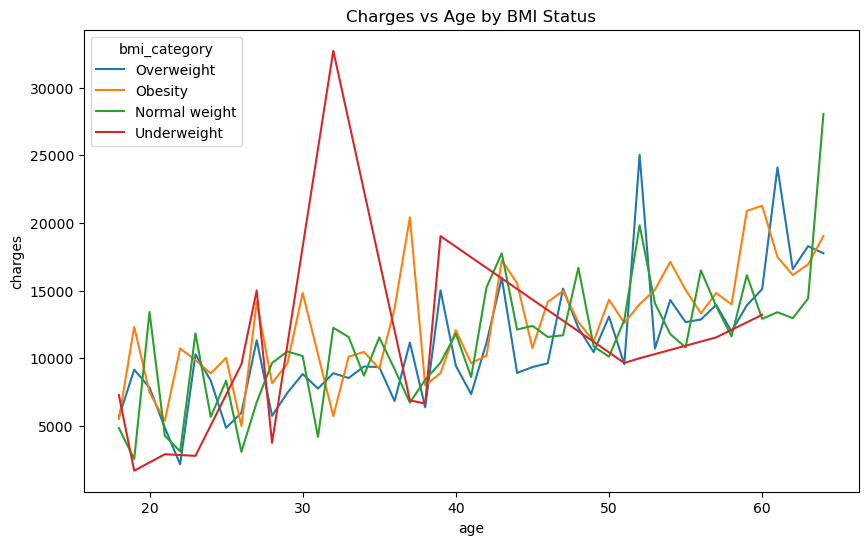

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='age', y='charges',hue='bmi_category',ci=None)
plt.title('Charges vs Age by BMI Status')

The charges among the BMI categories did not seem to really be affected by age. We however noticed a very sharp increase in charges within age 30 and by an underweight person. Let's keep this in mind as we keep exploring

For now let's check if the charges is affected by BMI status without considering age this time around

Text(0.5, 1.0, 'Charges vs BMI Status')

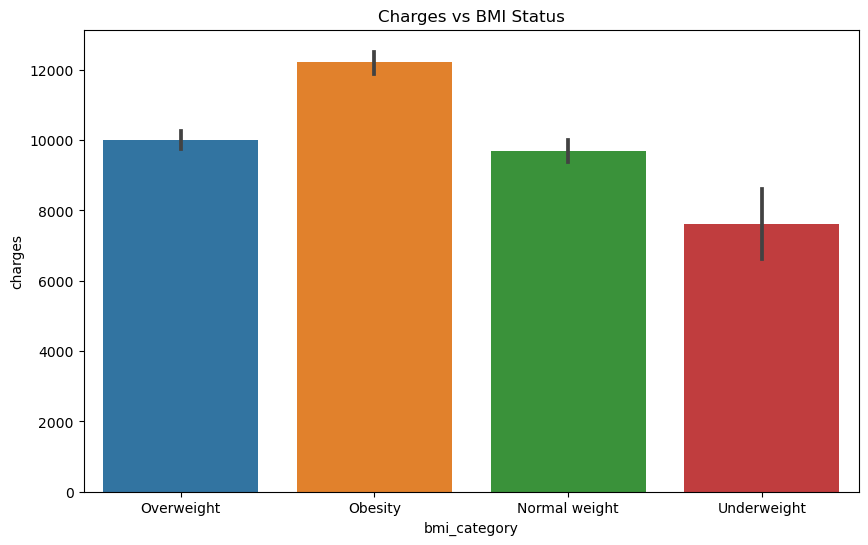

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='bmi_category', y='charges')
plt.title('Charges vs BMI Status')

As expected, an obesed person pays higher charges and the charges tend to decrease as the BMI decreases. So what could be the reason for an underweight person suddenly paying higher? If there are no other factors causing this then it must be a mistake or an outlier

Health Insurers reimburse you for amount spent on medical bills. In tune of this, they increase the charges when documentation shows that the insured(or prospect) has a high hospitalization history. lets find out if this applies to our data as well

Text(0.5, 1.0, 'Charges vs Age by Number of Past Hospitalizations')

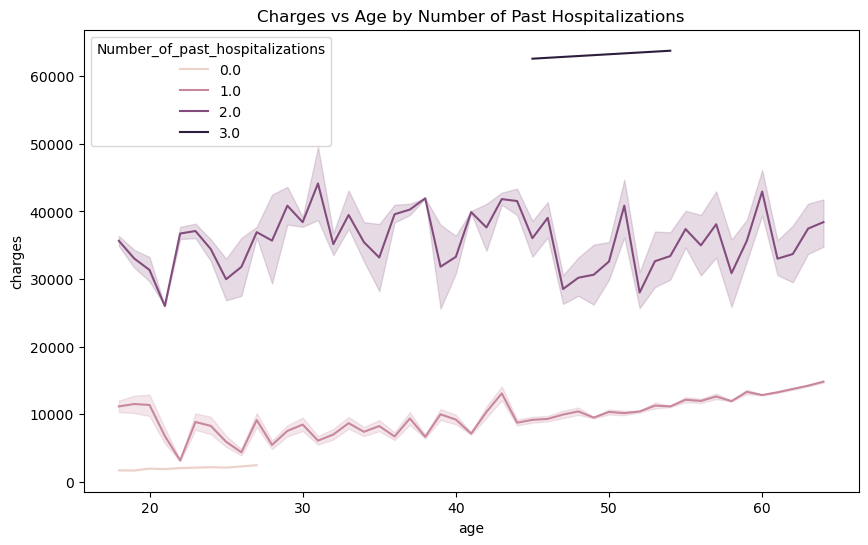

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='age', y='charges',hue='Number_of_past_hospitalizations')
plt.title('Charges vs Age by Number of Past Hospitalizations')

Good! Here we see that perons with 0 hospitalization history pay relatively low charge and they are young within the age 18-28 while persons with 3 hospitalization history pay the highest charges and they are within the ages of 45-55

Now we see the answer to the puzzle we were trying to solve earlier, why the sharp increase at age 30? His number of hospitalization is definitely one of the reasons despite being undeweight

Text(0.5, 1.0, 'Charges vs Numer of children')

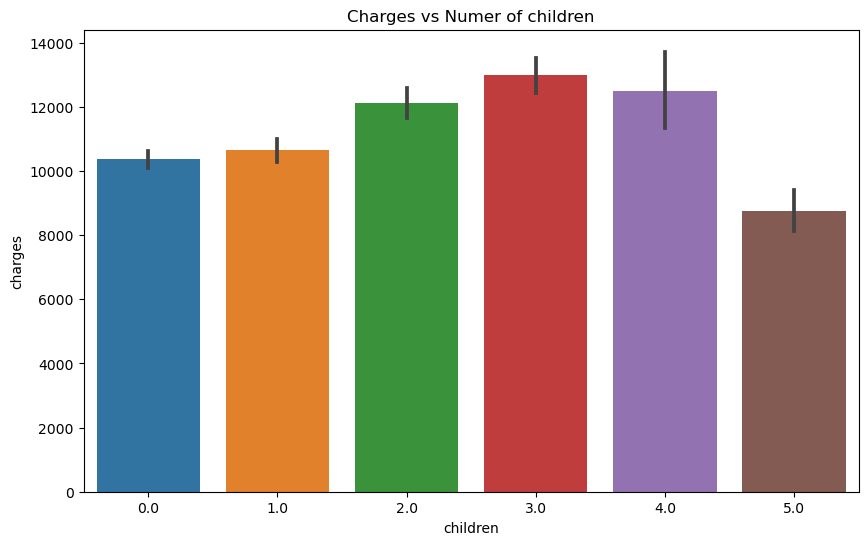

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='children', y='charges')
plt.title('Charges vs Numer of children')

This shows how charges increase as the number of children increases, however we see a decrease in charges from the 4th child, Isnt this amazing?

Text(0.5, 1.0, 'Charges vs sex')

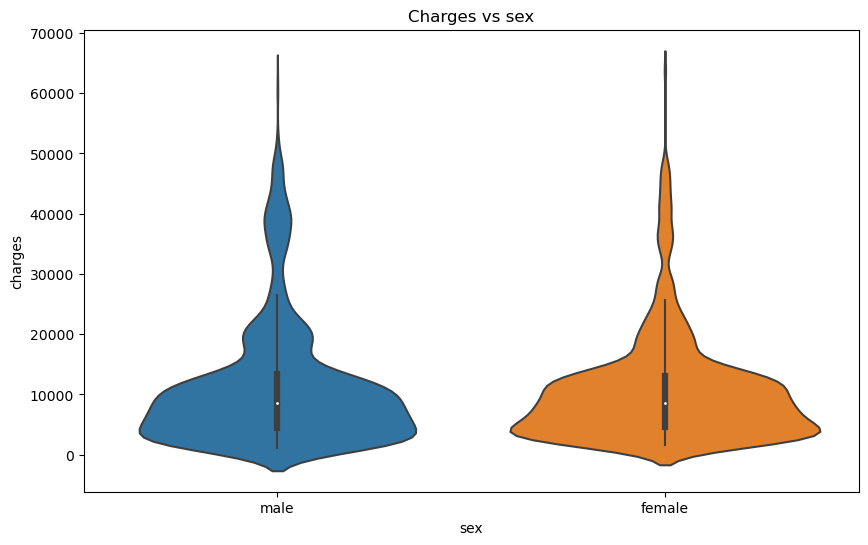

In [14]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=data, x='sex', y='charges')
plt.title('Charges vs sex')

There is no much difference between the charges paid by the male and female, in total, male pays a bit higher. Then considering the individual datapoints, the number of lower charges paid by the female is more than the number of higher charges paid

Now let's pause the exploration, i will be deleting the BMI category column that we added for the purpose of the exploration

In [20]:
data.drop(columns=['bmi_category'], inplace=True)

Now let's get a summary of this dataframe.

In [21]:
data.describe()

age          bmi     children  Claim_Amount  \
count  9935.000000  9984.000000  9963.000000   9909.000000   
mean     39.002416    30.435221     1.062632  32220.875871   
std      13.948819     6.112510     1.190579  15079.404127   
min      18.000000    15.960000     0.000000   1920.136268   
25%      26.000000    26.125000     0.000000  19540.950640   
50%      39.000000    30.030000     1.000000  32800.380850   
75%      51.000000    34.320000     2.000000  44147.667580   
max      64.000000    53.130000     5.000000  77277.988480   

       past_consultations  num_of_steps  Hospital_expenditure  \
count         9957.000000  9.984000e+03          9.978000e+03   
mean            14.416089  8.968627e+05          1.119890e+07   
std              6.895835  8.472179e+04          1.907507e+07   
min              1.000000  6.954300e+05          2.945253e+04   
25%              9.000000  8.419020e+05          3.776053e+06   
50%             14.000000  9.037690e+05          6.894887e+06   
75%             19.000000  9.492380e+05          9.721549e+06   
max             40.000000  1.107872e+06          2.616317e+08   

       Number_of_past_hospitalizations  Anual_Salary       charges  
count                      9998.000000  9.971000e+03  10008.000000  
mean                          0.972494  2.630171e+08  11024.933374  
std                           0.466700  4.191726e+08   9704.366543  
min                           0.000000  2.747072e+06   1121.873900  
25%                           1.000000  7.354224e+07   4441.213150  
50%                           1.000000  1.259020e+08   8549.519150  
75%                           1.000000  2.247415e+08  13224.057050  
max                           3.000000  4.117197e+09  63770.428010

Instantly, we see that there are missing values in this dataset judging from the fact that the counts are not equal to 10,008

We also see that this gives a summary of 10 columns out of 13 columns. Let's find out why.

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              9935 non-null   float64
 1   sex                              10008 non-null  object 
 2   bmi                              9984 non-null   float64
 3   children                         9963 non-null   float64
 4   smoker                           10008 non-null  object 
 5   Claim_Amount                     9909 non-null   float64
 6   past_consultations               9957 non-null   float64
 7   num_of_steps                     9984 non-null   float64
 8   Hospital_expenditure             9978 non-null   float64
 9   Number_of_past_hospitalizations  9998 non-null   float64
 10  Anual_Salary                     9971 non-null   float64
 11  region                           10008 non-null  object 
 12  charges           

A low volume of data is missing, this may not have any statistical impact however, most machine learning algorithms cannot handle missing data and may throw errors

We also have 3 categorical variables(object) too! Machine Learning Algorithms cannot directly handle objects.

Let's transform our data to suit this purposes.

# Data Transformation

In [23]:
# Convert categorical variables into dummy variables
data_dummies = pd.get_dummies(data, drop_first=True)

In [24]:
# Fill missing values with the mean of each column
data_dummies_filled = data_dummies.fillna(data_dummies.mean())

In [25]:
# Reorder columns to place 'charges' at the end
reorder_column = [col for col in data_dummies_filled.columns if col!= 'charges'] +['charges']
data = data_dummies_filled.reindex(columns=reorder_column)

In [26]:
data

age     bmi  children  Claim_Amount  past_consultations  num_of_steps  \
0      45.0  28.700       2.0   32993.77432                16.0      902022.0   
1      64.0  34.500       0.0   38448.37757                 8.0      956604.0   
2      19.0  32.110       0.0   50778.14448                15.0      758688.0   
3      36.0  28.880       3.0   33741.00388                10.0      879560.0   
4      19.0  24.605       1.0   12198.20493                16.0      793026.0   
...     ...     ...       ...           ...                 ...           ...   
10003  56.0  39.820       0.0   28716.57206                22.0      942062.0   
10004  28.0  24.300       5.0   50103.89082                20.0      851136.0   
10005  19.0  30.590       2.0   44541.59053                11.0     1004840.0   
10006  22.0  19.950       3.0   46464.83222                 3.0      827067.0   
10007  27.0  23.210       1.0   11003.85343                 4.0      815134.0   

       Hospital_expenditure  Number_of_past_hospitalizations  Anual_Salary  \
0              8.640895e+06                              1.0  9.436591e+07   
1              1.102239e+07                              1.0  2.300219e+08   
2              1.642626e+06                              0.0  4.644349e+07   
3              1.985637e+06                              1.0  1.306169e+08   
4              1.000938e+07                              1.0  6.113392e+07   
...                     ...                              ...           ...   
10003          8.381702e+06                              1.0  1.957085e+08   
10004          8.206516e+06                              1.0  8.685767e+07   
10005          1.771344e+07                              2.0  6.725722e+08   
10006          7.843290e+06                              1.0  3.423338e+07   
10007          4.585253e+06                              1.0  6.941127e+07   

       sex_male  smoker_yes  region_northwest  region_southeast  \
0          True       False             False             False   
1          True       False             False             False   
2         False       False              True             False   
3          True       False             False             False   
4         False       False              True             False   
...         ...         ...               ...               ...   
10003     False       False             False              True   
10004      True       False             False             False   
10005     False       False              True             False   
10006      True       False             False             False   
10007     False       False             False              True   

       region_southwest      charges  
0                  True   8027.96800  
1                  True  13822.80300  
2                 False   2130.67590  
3                 False   6748.59120  
4                 False   2709.24395  
...                 ...          ...  
10003             False  11090.71780  
10004              True   5615.36900  
10005             False  24059.68019  
10006             False   4005.42250  
10007             False   3561.88890  

[10008 rows x 15 columns]

And there we have our transformed data. The categorical texts has been transformed into Boolean by adding a column for each distinct category. We now have 15 columns!

Nulls have been filled with the mean of their respective columns and 'charges' has been shifted back to the end of the dataframe.

In [27]:
data.isna().sum()

age                                0
bmi                                0
children                           0
Claim_Amount                       0
past_consultations                 0
num_of_steps                       0
Hospital_expenditure               0
Number_of_past_hospitalizations    0
Anual_Salary                       0
sex_male                           0
smoker_yes                         0
region_northwest                   0
region_southeast                   0
region_southwest                   0
charges                            0
dtype: int64

# Correlation

Now let's analyse the relationships between variables in our dataset.

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
C:\Users\Wealth\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2500x1500 with 0 Axes>

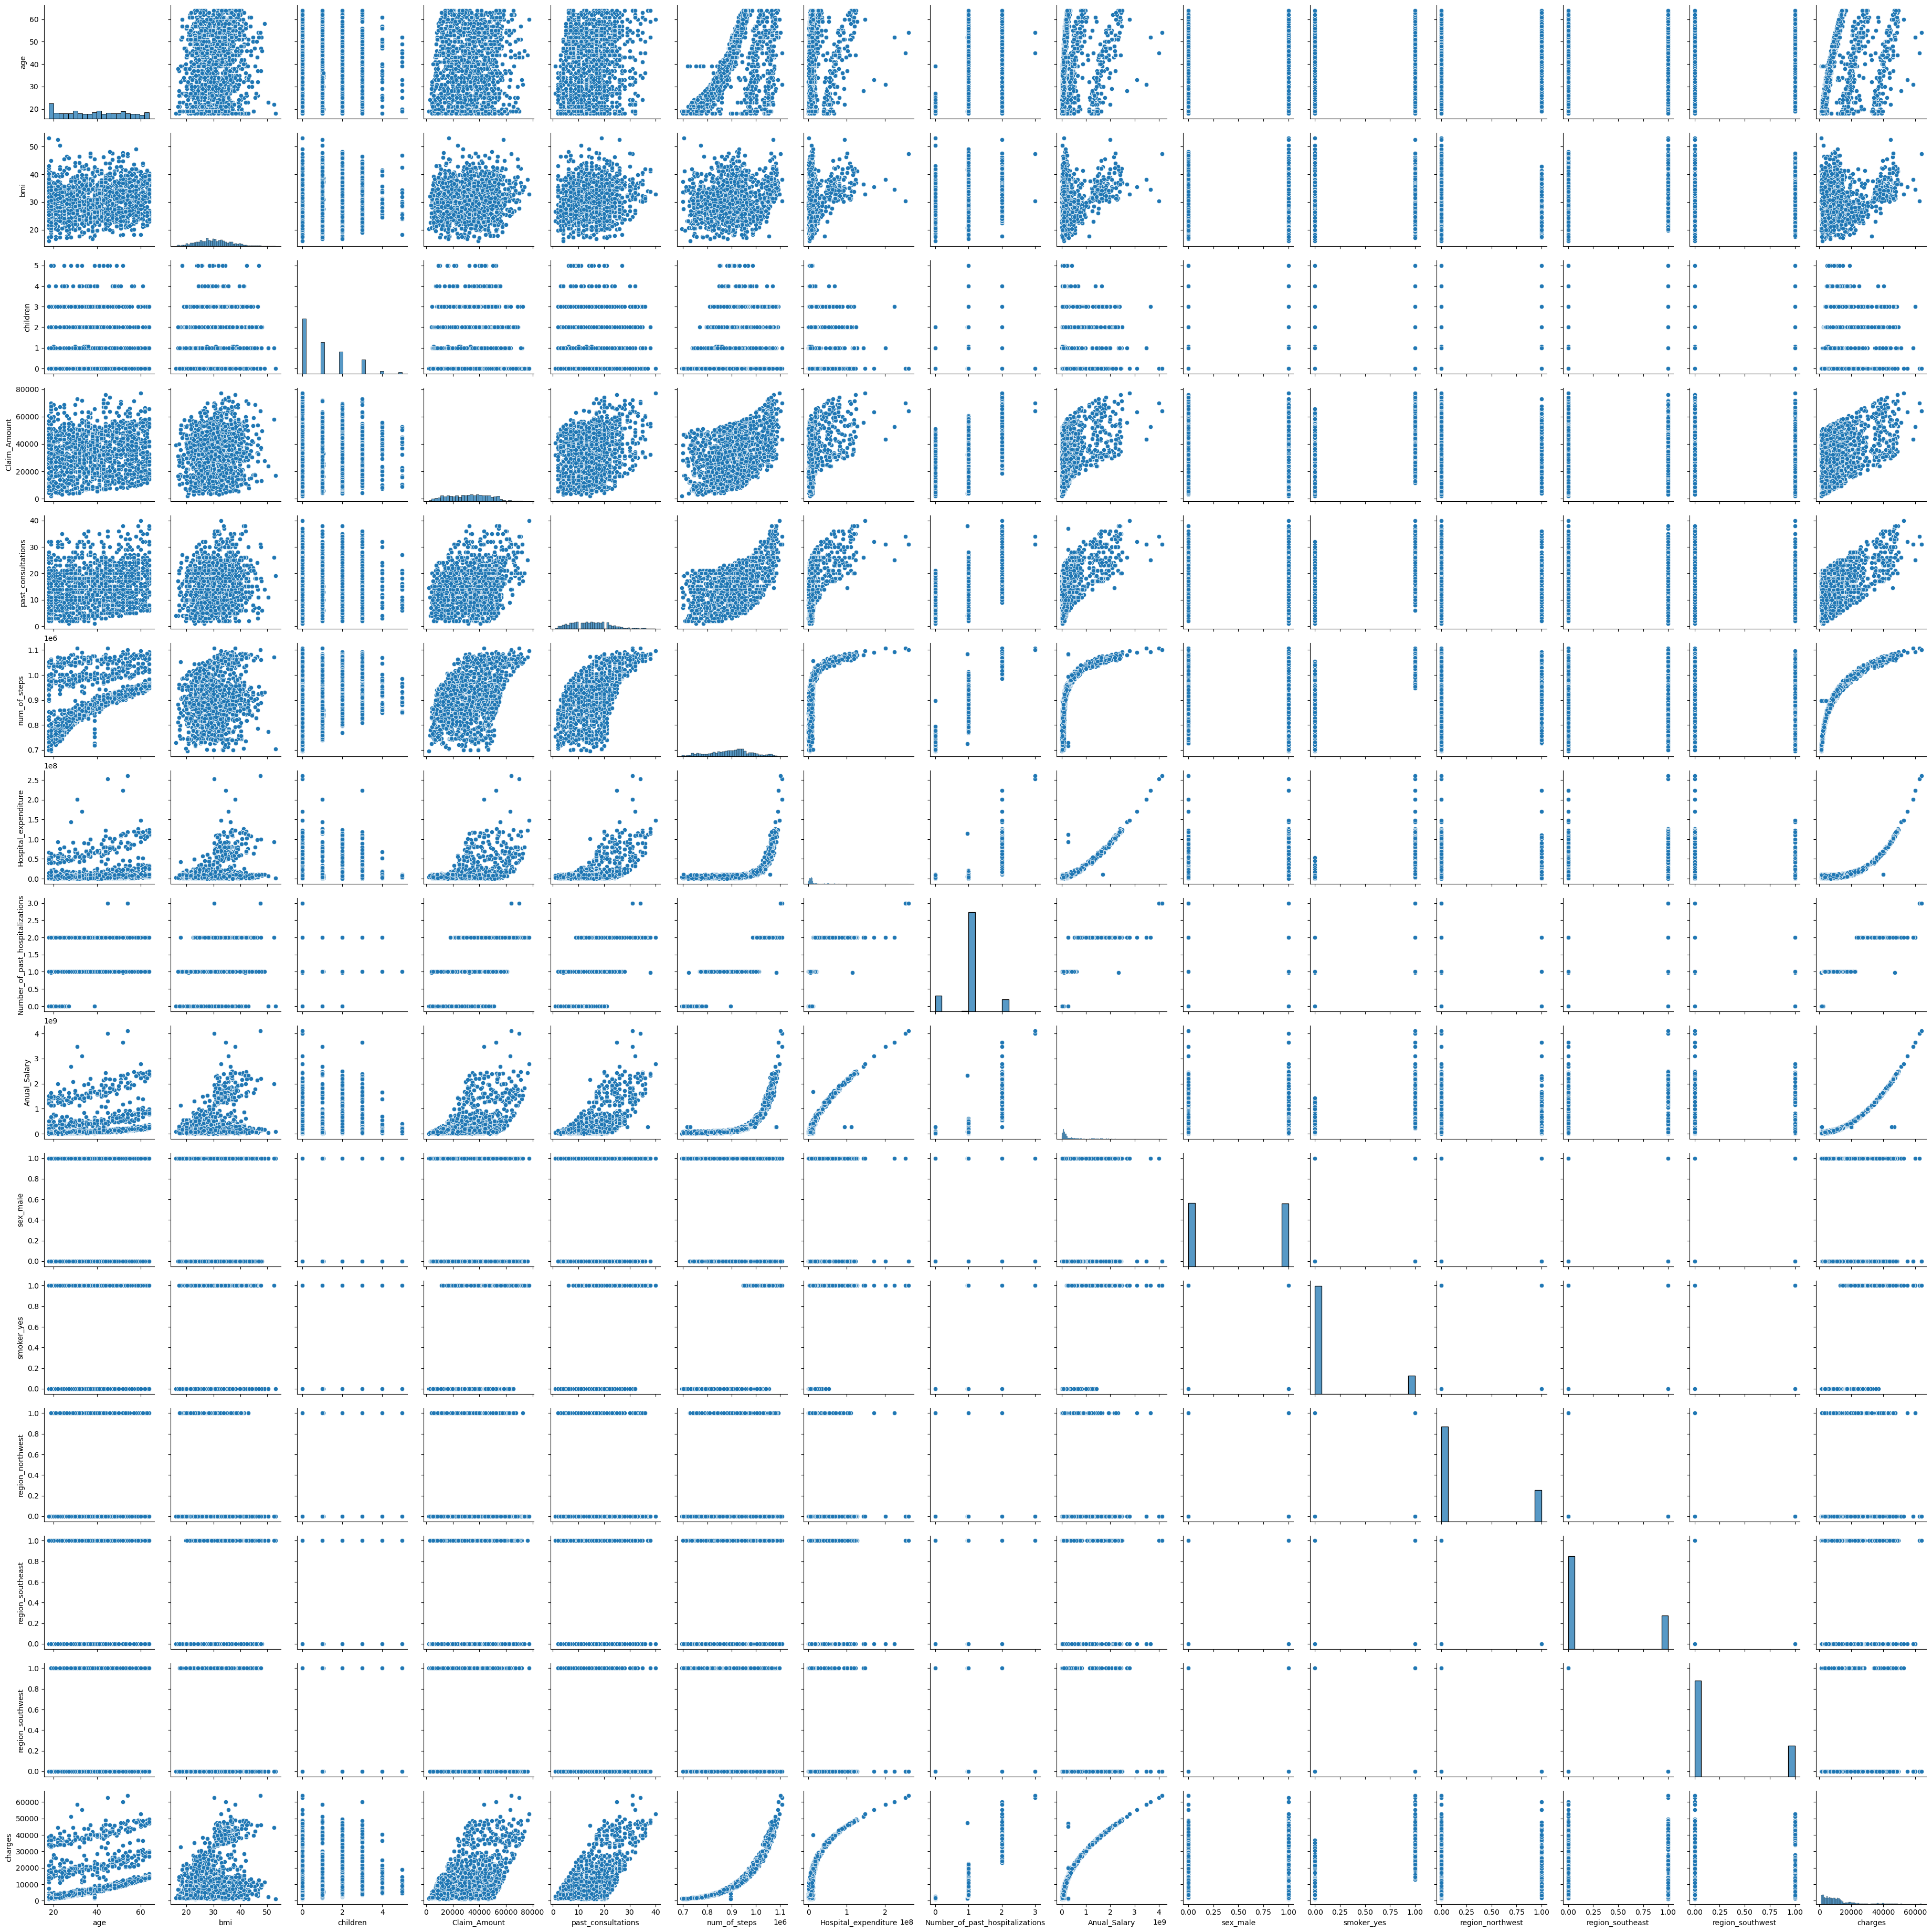

In [28]:
plt.figure(figsize=(25,15))
sns.pairplot(data)
plt.show()

Firstly, Let's concentrate on the "charges" Matrix, We see the strong correlation it has with Annual_salary, Hospital_expenditure and number_of steps.


We also see predictor variables that are correlated with each other such as 'Hospital_expenditure' and 'Annual_salary' This is not a good sign as multicollinearity undermines the statistical significance of individual predictors. We will address this through cross validation and other measures during model building.

Now, Let's have a clearer view of this

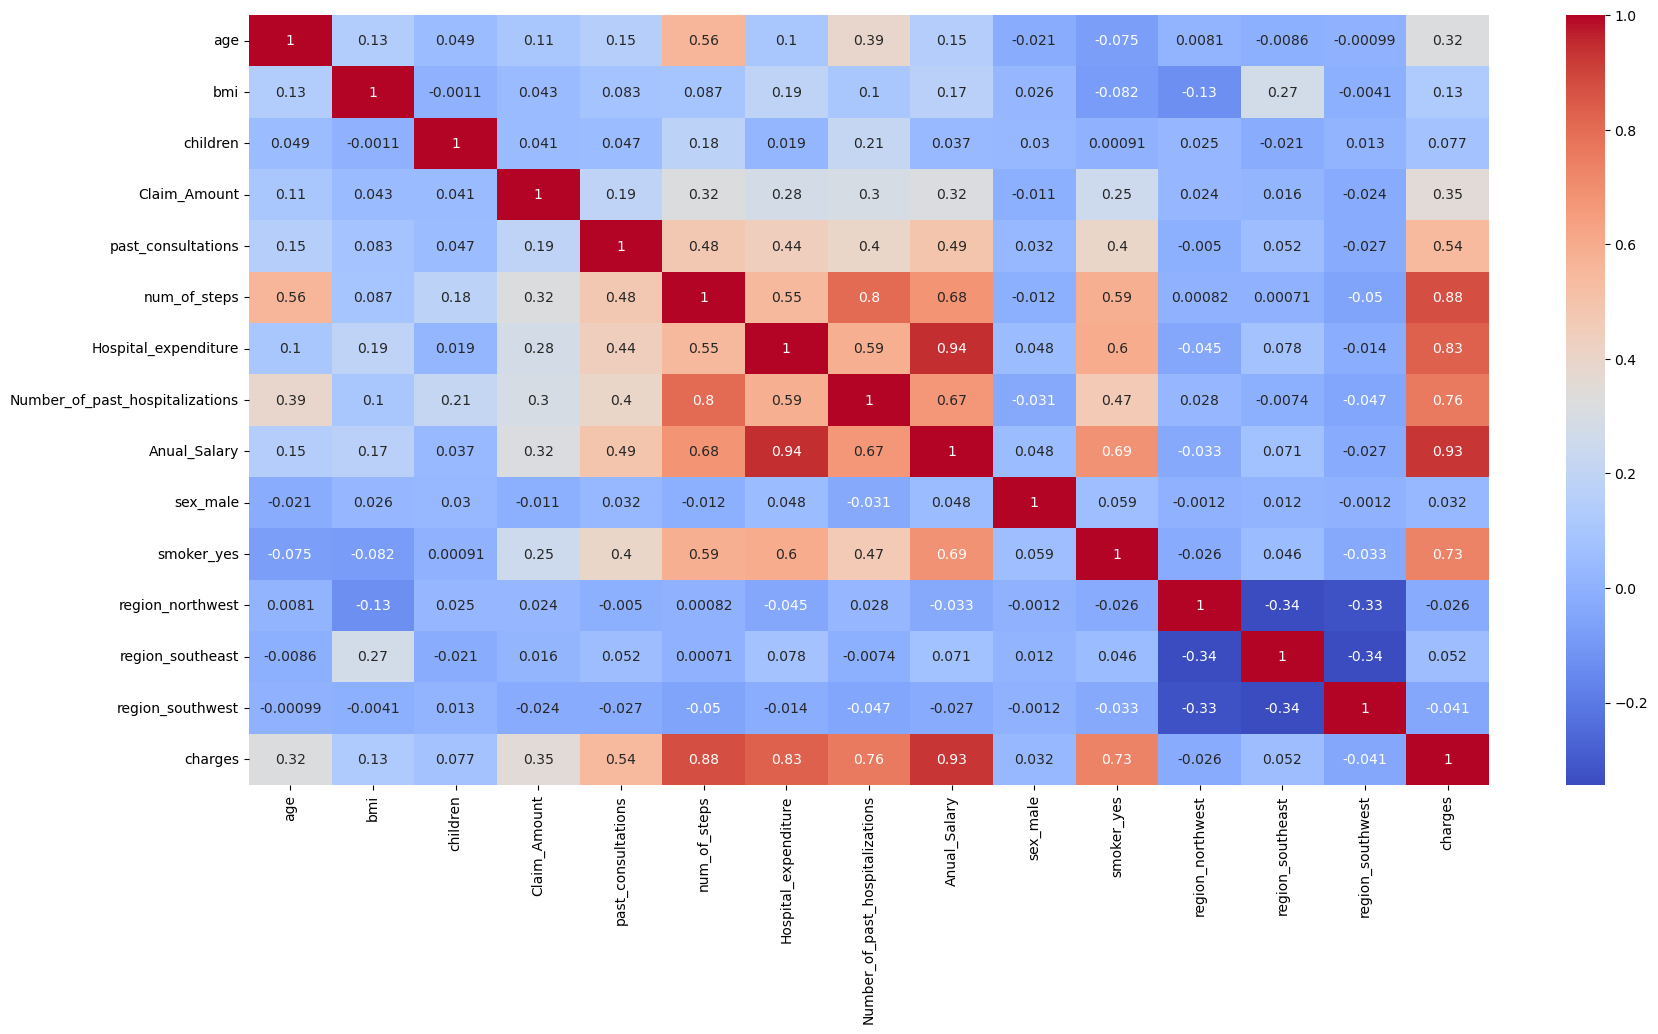

In [29]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

Let's check the order in which each variable is correlated with "Charges"

In [30]:
data.corr()['charges'].sort_values(ascending=False)

charges                            1.000000
Anual_Salary                       0.929704
num_of_steps                       0.876005
Hospital_expenditure               0.831695
Number_of_past_hospitalizations    0.762175
smoker_yes                         0.734781
past_consultations                 0.539188
Claim_Amount                       0.350174
age                                0.321619
bmi                                0.127389
children                           0.077073
region_southeast                   0.052483
sex_male                           0.032251
region_northwest                  -0.025518
region_southwest                  -0.041097
Name: charges, dtype: float64

# Data Preprocessing

In [31]:
# Separate the Predictive and response variables
X = data.drop('charges', axis=1)
y = data['charges']

Now let's scale the predictive variables to ensure that there is no bias towards variables with larger magnitudes. After this, we will have a view of the new scaled data.

In [32]:
# Initialize and apply StandardScaler for scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
X_standardised = pd.DataFrame(X_scaled, columns=X.columns)

In [34]:
X_standardised.head()

age       bmi  children  Claim_Amount  past_consultations  \
0  0.431569 -0.284236  0.789137      0.051513            0.230290   
1  1.798756  0.665826 -0.894592      0.415059           -0.932856   
2 -1.439317  0.274335 -0.894592      1.236831            0.084897   
3 -0.216045 -0.254751  1.631002      0.101316           -0.642070   
4 -1.439317 -0.955011 -0.052727     -1.334500            0.230290   

   num_of_steps  Hospital_expenditure  Number_of_past_hospitalizations  \
0      0.060973             -0.134310                         0.058969   
1      0.706029             -0.009268                         0.058969   
2     -1.632964             -0.501760                        -2.084914   
3     -0.204485             -0.483750                         0.058969   
4     -1.227153             -0.062457                         0.058969   

   Anual_Salary  sex_male  smoker_yes  region_northwest  region_southeast  \
0     -0.403109  1.005611   -0.412617         -0.573812         -0.599511   
1     -0.078865  1.005611   -0.412617         -0.573812         -0.599511   
2     -0.517653 -0.994420   -0.412617          1.742731         -0.599511   
3     -0.316462  1.005611   -0.412617         -0.573812         -0.599511   
4     -0.482540 -0.994420   -0.412617          1.742731         -0.599511   

   region_southwest  
0           1.76258  
1           1.76258  
2          -0.56735  
3          -0.56735  
4          -0.56735

In [35]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=1,
                                                    shuffle=False)

# Statistical Modelling and Evaluation

We had a look at the correltion heatmap and we could see the presence of linearity in most of the variables with "Charges"

This makes me want to check out the Linear Regression Model and see its performance.

### Linear Regression Model

In [36]:
#Create the model object, train and evaluate the model
lm = LinearRegression()


lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

linear_r2 = r2_score(y_test, y_pred)
linear_mse = mean_squared_error(y_test, y_pred)

print(f'Linear_Regression \nR2: {linear_r2} \nMSE: {linear_mse}')

Linear_Regression 
R2: 0.985140543455865 
MSE: 1350098.9759302528


A 98% R-squared is awesome however the MSE is quite on the high side. Let's explore visually the performance of the model and see how the prediction fits the actual data.

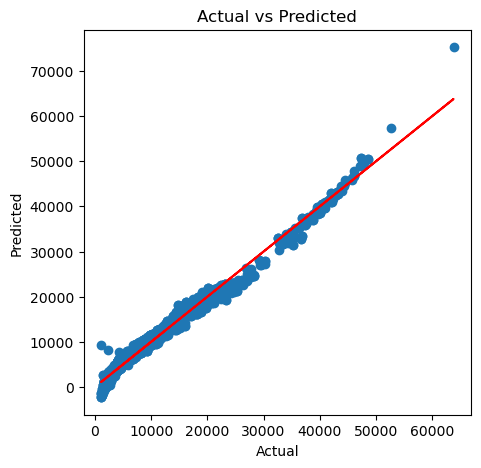

In [37]:
f, ax = plt.subplots(figsize=(5,5))

# Plot actual vs. predicted values on axes
ax.set_title('Actual vs Predicted')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.scatter(y_test,y_pred)
ax.plot(y_test,y_test,'r')
plt.show()

This is quite impressive. Though the MSE may be high, the model was able to predict the values to a high degree! 

However, lets explore a quite complex model this time around called Random Forest.

A random forest combines multiple Decision Tree models. Yes i did try using a standalone decision tree model and it came out perfect but maybe too perfect. It perfectly fitted the individual datapoints but the question is, Does it fit the overall properties of the distribution? I do not want to take that risk so instead, i will use a Random Forest which uses an aggregated result from multiple Decision tree models. I did some search and discovered this model worked better without tunning its hyper parameters.

# Ensemble Models

### Random Forest

In [39]:
#Create the model object, train and evaluate the model
rf = RandomForestRegressor(random_state=30) 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_r2 = r2_score(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)

print(f'rf \nR2: {rf_r2} \nMSE: {rf_mse}')

rf 
R2: 0.9999902480017906 
MSE: 886.0460513266667


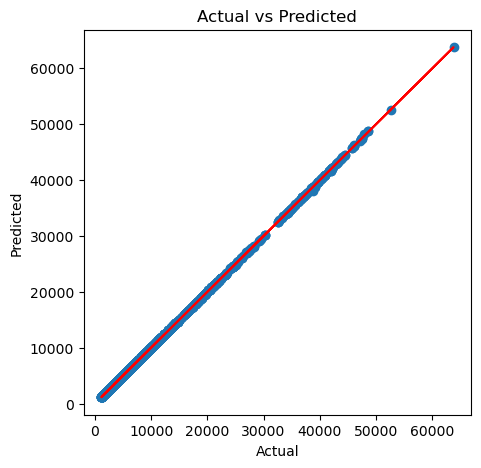

In [40]:
f, ax = plt.subplots(figsize=(5,5))

# Plot actual vs. predicted values on axes
ax.set_title('Actual vs Predicted')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.scatter(y_test,y_pred)
ax.plot(y_test,y_test,'r')
plt.show()

Perfect! 

Knowing that a linear relationship exists between "Charges" and most of the other variables, and seeing that my actual vs predicted values display a strong linearity, I would like to combine this perfect Random Forest with the Linear model to see how it goes

### Linear Regression and Random Forest

In [41]:
# Define the base models
base_models = [
    ('Linear_model', lm),
    ('random_forest', rf)
]

# Define the meta-learner
final_estimator = LinearRegression()

# Training and evaluating the stacking regression model
stacked_model_1 = StackingRegressor(estimators=base_models, final_estimator=final_estimator, cv=5)

stacked_model_1.fit(X_train, y_train)
y_pred = stacked_model_1.predict(X_test)
stacked_r2 = r2_score(y_test, y_pred)
stacked_mse = mean_squared_error(y_test, y_pred)
print(f'Stacked_Model_1 \nR2: {stacked_r2} \nMSE: {stacked_mse}')

Stacked_Model_1 
R2: 0.9999902995283861 
MSE: 881.3644532011003


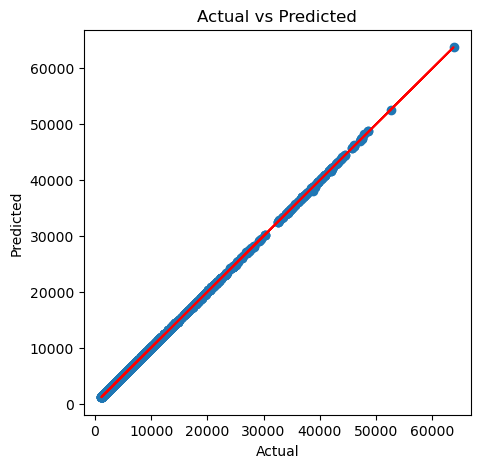

In [42]:
f, ax = plt.subplots(figsize=(5,5))

# Plot actual vs. predicted values on axes
ax.set_title('Actual vs Predicted')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.scatter(y_test,y_pred)
ax.plot(y_test,y_test,'r')
plt.show()

### Linear Regression and XGBoost

I will also be trying out the XGBoost out of curiosity. I have heard so much about it and how great it is for Stacked model. This model performed better when the hyper parameters were tuned. I would as well be combining it with the linear model

In [27]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/a2/48/d5da8591891327b0faf08179d420fba3893c6134bdd449497c5329e4cb01/xgboost-2.1.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 325.1 kB/s eta 0:06:25
   ---------------------------------------- 0.0/124.9 MB 325.1 kB/s eta 0:06:25
   ---------------------------------------- 0.0/124.9 MB 178.6 kB/s eta 0:11:40
   ---------------------------------------- 0.1/124.9 MB 251.0 kB/s eta 0:08:18
   ---------------------------------------- 0.1/124.9 MB 308.0 kB/s eta 0:06:46
   ---------------------------------------- 0.1/124.9 MB 327.2 kB/s eta 0:06:22
   ---------------------------------------- 0.1/124.9 MB 314.3 kB/s eta 0:06:37
   ---------------------------------------- 0.2/124.9 MB 388.2 kB/s eta 0:05:22
   ----------

^C
Note: you may need to restart the kernel to use updated packages.


In [43]:
xgb = XGBRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [3, 5, 7],           
    'learning_rate': [0.01, 0.1, 0.2] 
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='r2')

grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_xgb = grid_search.best_estimator_

# Predict using the best model
y_pred = best_xgb.predict(X_test)

# Evaluate the model performance
xgb_r2 = r2_score(y_test, y_pred)
xgb_mse = mean_squared_error(y_test, y_pred)

print(f'XGBRegressor \nR2: {xgb_r2} \nMSE: {xgb_mse}')

XGBRegressor 
R2: 0.9999961376329066 
MSE: 350.9265525296249


In [44]:
# Define the base models
base_models = [
    ('Linear_model', lm),
    ('XGBoost', best_xgb)
]

# Define the meta-learner
final_estimator = LinearRegression()

# Training and evaluating the stacking regression model
stacked_model_2 = StackingRegressor(estimators=base_models, final_estimator=final_estimator, cv=5)

stacked_model_2.fit(X_train, y_train)
y_pred = stacked_model_2.predict(X_test)
stacked_r2 = r2_score(y_test, y_pred)
stacked_mse = mean_squared_error(y_test, y_pred)
print(f'Stacked_Model_2 \nR2: {stacked_r2} \nMSE: {stacked_mse}')

Stacked_Model_2 
R2: 0.9999959810809577 
MSE: 365.15053341755


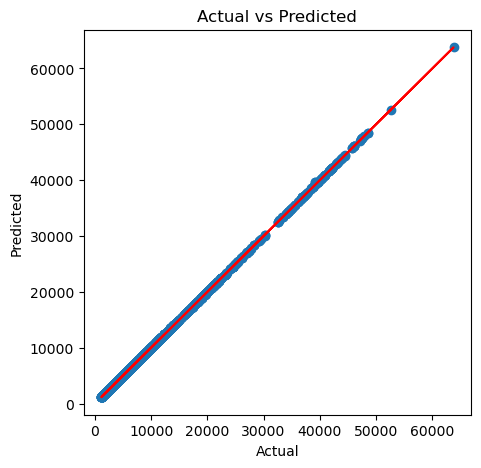

In [45]:
f, ax = plt.subplots(figsize=(5,5))

# Plot actual vs. predicted values on axes
ax.set_title('Actual vs Predicted')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.scatter(y_test,y_pred)
ax.plot(y_test,y_test,'r')
plt.show()

Beautiful!

We will hence select the ensemble of Linear Regression and XGBoost models beacause:

XGBoost had the highest predictive accuracy

It has the track record of being excellent for stacking

Linearity exists in our data

Linear regression embraces simplicity and we would love to combine this with the speed and excellence of XGBoost